In [37]:
from os.path import join as opj
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [38]:
data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path)
rna = data['rna_train']
atac = data['atac_train_small']

In [39]:
def zero_frac(arr):
    zero_count = np.count_nonzero(arr==0)
    return zero_count/arr.size

In [40]:
print('rna zero frac:', zero_frac(rna))
print('atac zero frac:', zero_frac(atac))

rna zero frac: 0.0
atac zero frac: 0.9740022531413609


In [41]:
list(data.keys())

['peak_selector',
 'atac_train_small',
 'atac_test_small',
 'rna_train',
 'rna_test',
 'rna_good_feats',
 'train_idx',
 'test_idx',
 'cell_type_train',
 'cell_type_test']

In [42]:
import torch
torch.cuda.is_available()

True

In [43]:
def self_correlation(matrix, device='cuda:0'):
    matrix = torch.Tensor(matrix).to(device)
    # return matrix.T @ matrix
    return torch.corrcoef(matrix.T)

train_rna = data['rna_train']
train_atac = data['atac_train_small']
rna_embedding = self_correlation(train_rna)
atac_embedding = self_correlation(train_atac)

In [44]:
import pandas as pd
gene_list = pd.read_csv(f'{data_root}/gene_list.csv', header=None)

In [45]:
chosen_genes = gene_list[data['rna_good_feats']]

In [46]:
from os.path import join as opj
import numpy as np

data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path, allow_pickle=True)
cell_labels_train = data['cell_type_train']

In [47]:
cell_labels_train.shape

(6897,)

In [48]:
from GanoliModel import GanoliLogisticGAN
model_cls = GanoliLogisticGAN

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
checkpoint_dir = '/om2/user/rogerjin/GANOLI/ganoli/models/logs/logistic_embed_corr/default/version_0/checkpoints/'
checkpoint = 'epoch=52-val_oracle_total=1.29.ckpt'
checkpoint_path = f'{checkpoint_dir}/{checkpoint}'
ckpt_model = model_cls.load_from_checkpoint(checkpoint_path=checkpoint_path, rna_shape=7445, atac_shape=3808, rna_embedding=rna_embedding, atac_embedding=atac_embedding)

In [51]:
ckpt_model.to('cuda:0')

GanoliLogisticGAN(
  (generator_rna2atac): GanoliLogisticGenerator(
    (linear): Linear(in_features=7445, out_features=3808, bias=True)
    (sigmoid): Sigmoid()
  )
  (generator_atac2rna): GanoliLinearGenerator(
    (model): Linear(in_features=3808, out_features=7445, bias=True)
  )
  (discriminator_rna): GanoliLinearDiscriminator(
    (model): Linear(in_features=7445, out_features=1, bias=True)
  )
  (discriminator_atac): GanoliLinearDiscriminator(
    (model): Linear(in_features=3808, out_features=1, bias=True)
  )
  (reconstruction_loss_fn): MSELoss()
  (identity_loss_fn): MSELoss()
  (generator_loss_fn): BCEWithLogitsLoss()
  (discriminator_loss_fn): BCEWithLogitsLoss()
)

In [52]:
atac_val = data['atac_test_small']

In [53]:
import torch
atac_val = torch.Tensor(atac_val).to('cuda:0')

In [54]:
atac_val_mini = atac_val[:10, :]

In [55]:
rna_val_pred = ckpt_model(atac_val,data_type='atac')

In [56]:
rna_val_pred.shape

torch.Size([2300, 7445])

In [57]:
rna_val_labels = data['cell_type_test']

In [58]:
import umap
reducer = umap.UMAP(densmap=True) 
rna_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())

In [59]:
rna_trans.shape

(2300, 2)

In [60]:
import benplot

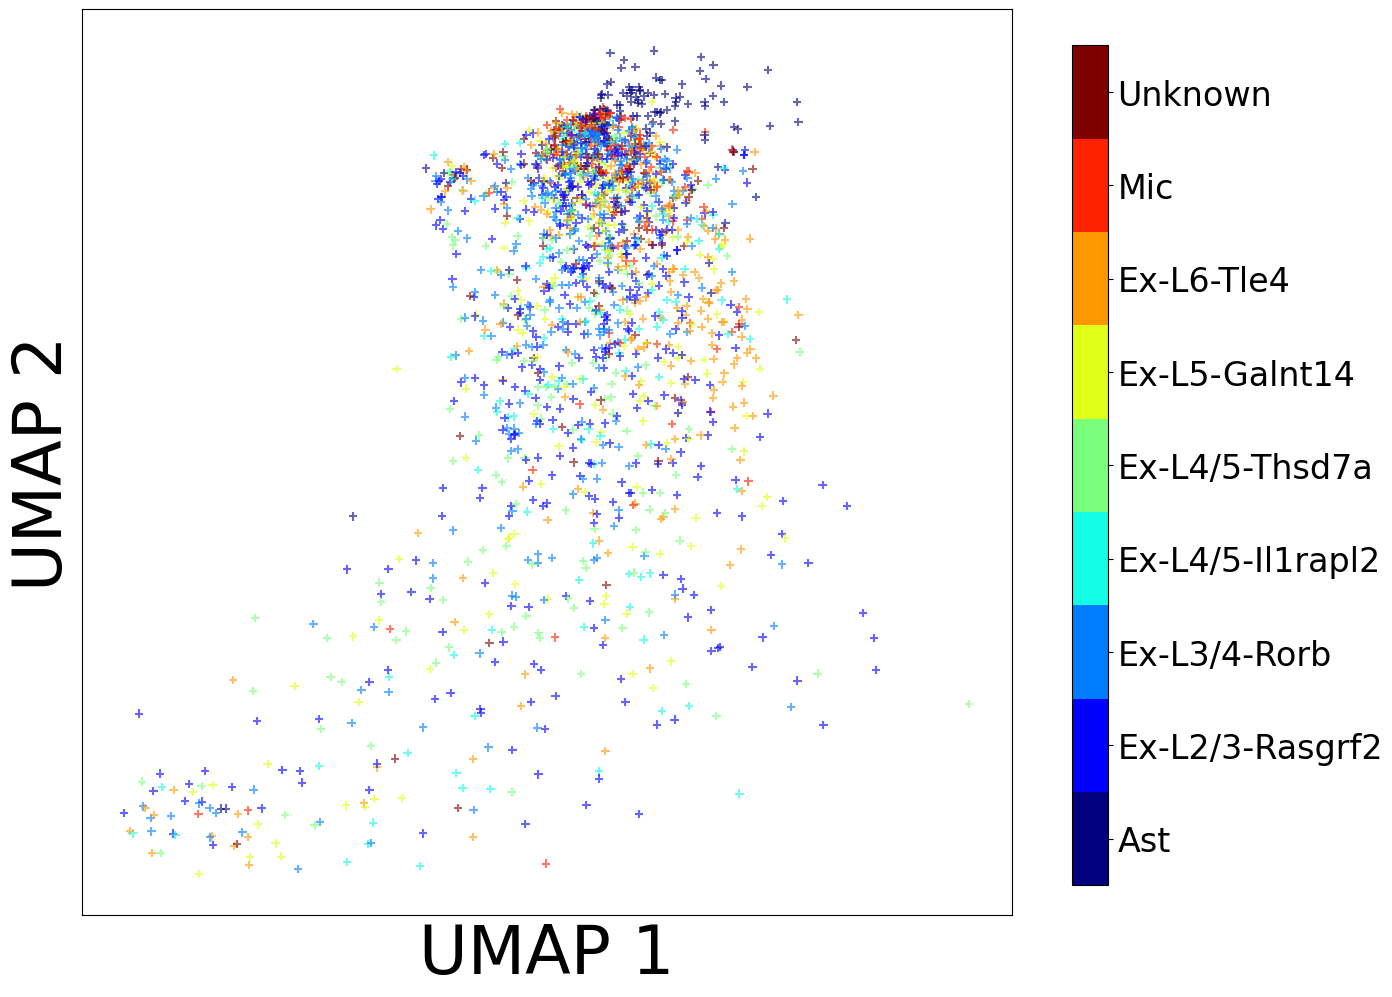

In [61]:
benplot.plot_lowdim_rep(rna_trans, rna_val_labels)

In [62]:
rna_val = data['rna_test']
reducer = umap.UMAP(densmap=True, min_dist=0.001) 
rna_true_trans = reducer.fit_transform(rna_val)

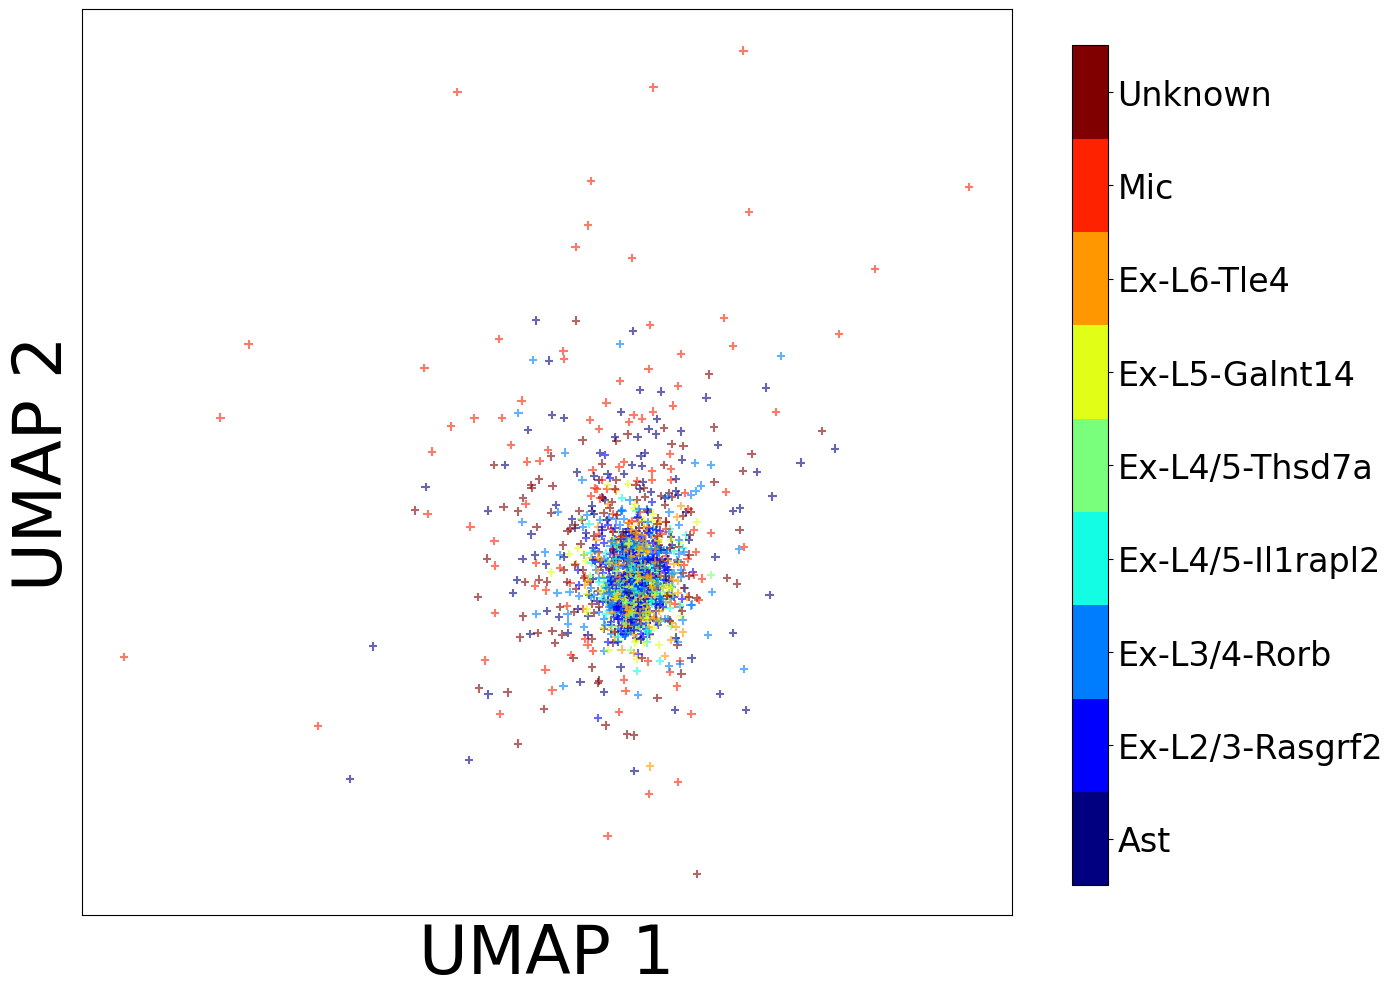

In [63]:
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels)

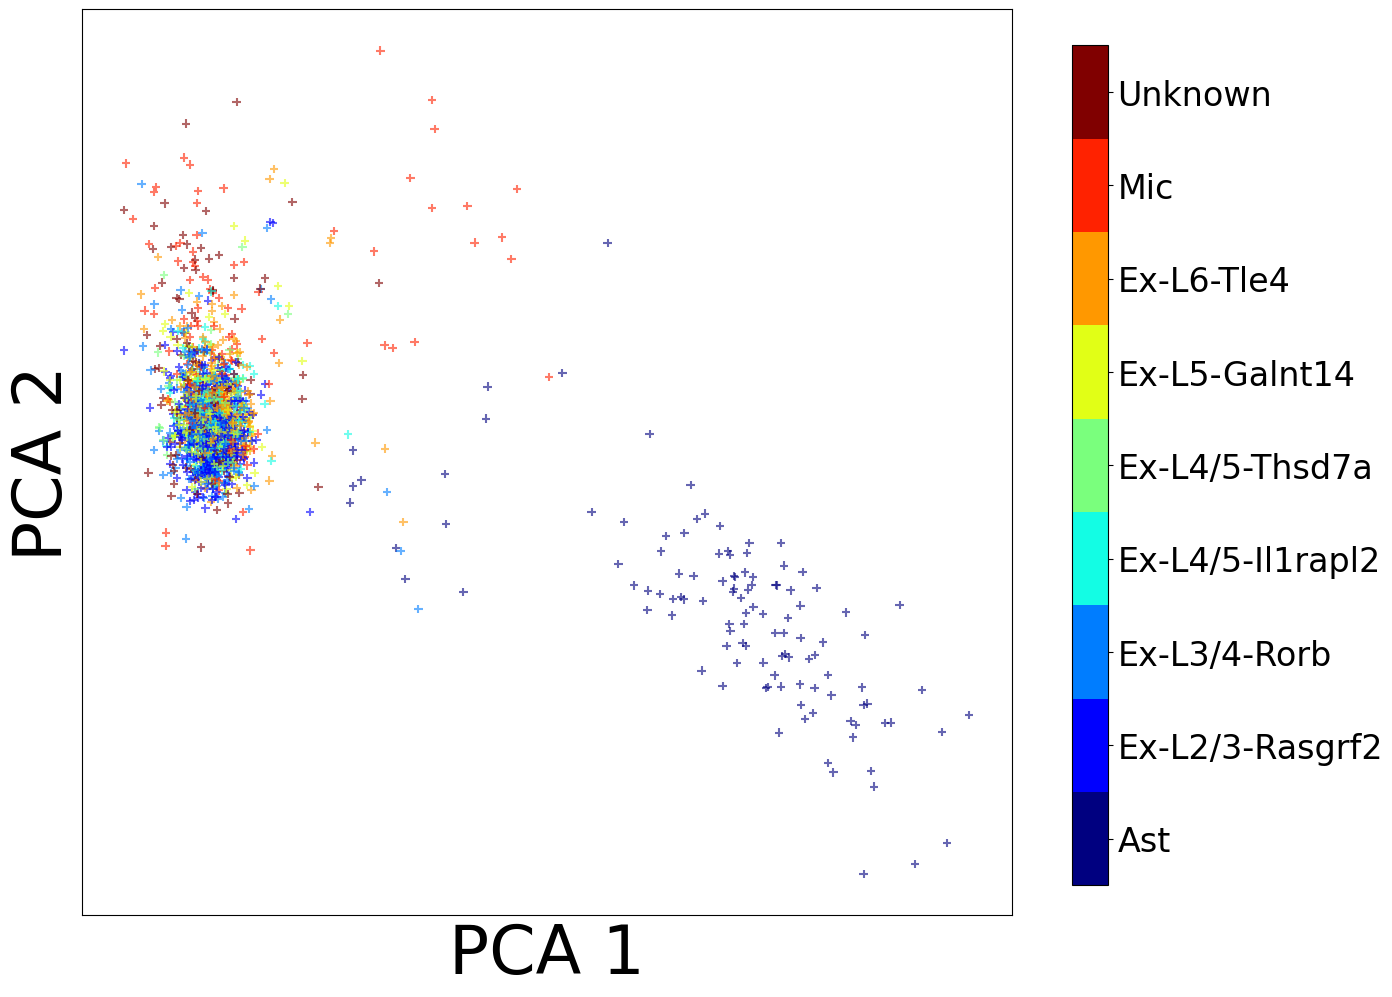

In [64]:
from sklearn.decomposition import PCA

rna_val = data['rna_test']
reducer = PCA(n_components=2) 
rna_true_trans = reducer.fit_transform(rna_val)
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels, xlabel='PCA 1', ylabel='PCA 2')

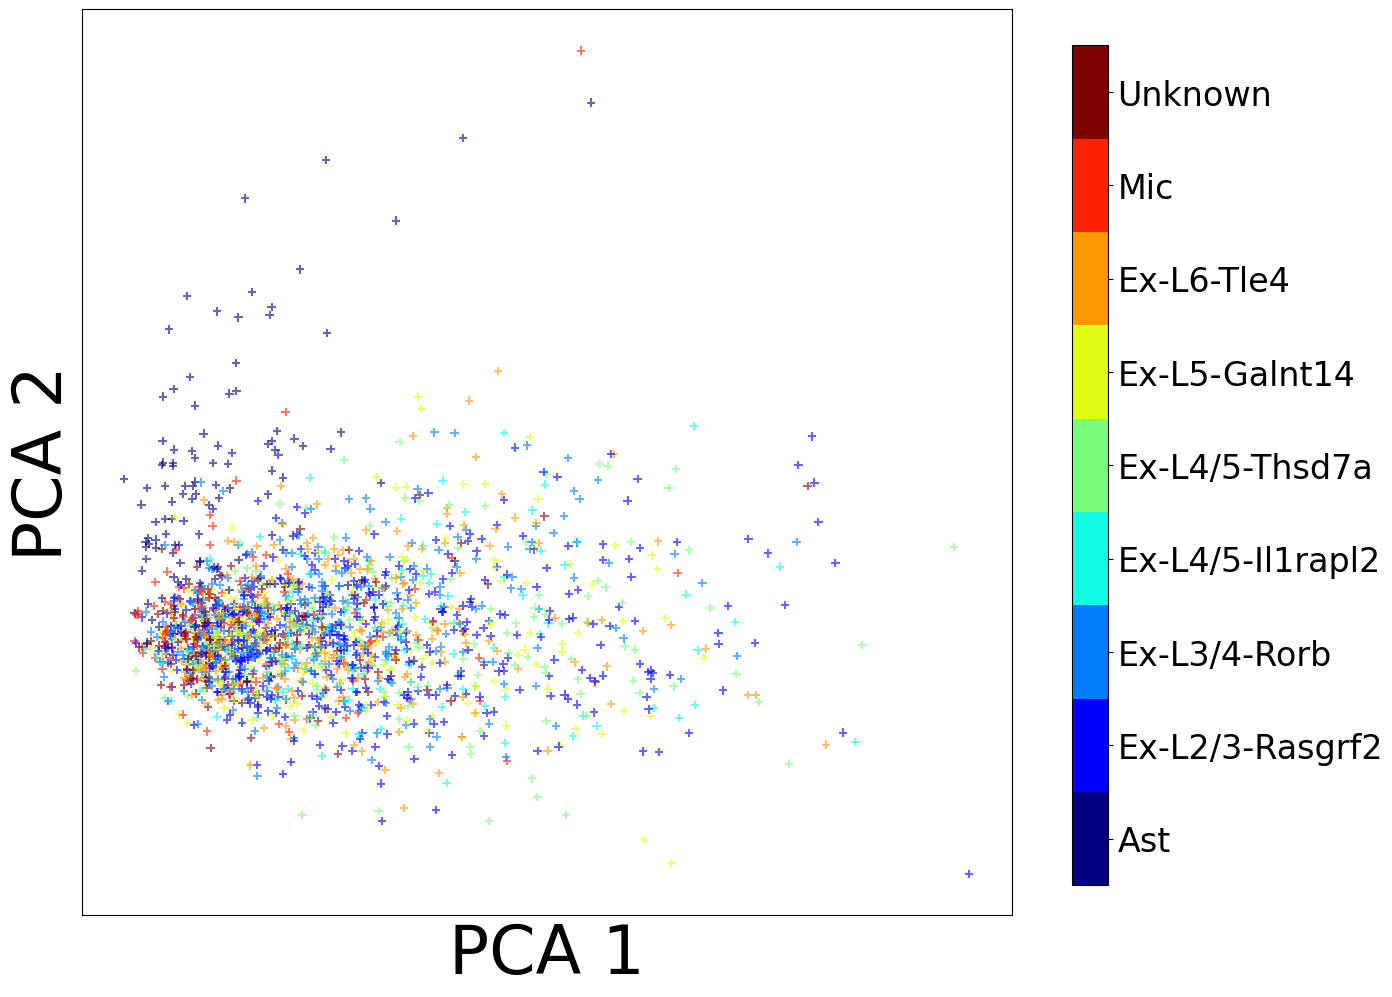

In [65]:
reducer = PCA(n_components=2) 
rna_pred_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())
benplot.plot_lowdim_rep(rna_pred_trans, rna_val_labels, xlabel='PCA 1', ylabel='PCA 2')

In [66]:
rna_val = torch.Tensor(rna_val).to('cuda:0')
atac_val_pred = ckpt_model(rna_val,data_type='rna')

In [67]:
atac_val_pred

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.1060e-29, 7.0656e-22, 0.0000e+00,  ..., 1.8484e-31, 0.0000e+00,
         0.0000e+00],
        [1.9512e-29, 1.3664e-25, 8.2717e-38,  ..., 2.1103e-26, 5.0161e-38,
         3.5265e-35],
        ...,
        [4.1515e-36, 6.3891e-38, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0266e-20, 1.0000e+00, 3.9438e-12,  ..., 1.5689e-05, 9.8532e-01,
         1.0100e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [68]:
atac_val_pred

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.1060e-29, 7.0656e-22, 0.0000e+00,  ..., 1.8484e-31, 0.0000e+00,
         0.0000e+00],
        [1.9512e-29, 1.3664e-25, 8.2717e-38,  ..., 2.1103e-26, 5.0161e-38,
         3.5265e-35],
        ...,
        [4.1515e-36, 6.3891e-38, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0266e-20, 1.0000e+00, 3.9438e-12,  ..., 1.5689e-05, 9.8532e-01,
         1.0100e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [69]:
type(atac_val)

torch.Tensor

In [70]:
from sklearn.metrics import roc_auc_score
import pandas as pd

aurocs = []
for i in range(atac_val.shape[1]):
    auroc = roc_auc_score(atac_val[:, i].detach().cpu().numpy(), atac_val_pred[:, i].detach().cpu().numpy())
    aurocs.append(auroc)

atac_rocs = pd.DataFrame()
atac_rocs['auroc'] = aurocs

array([[<AxesSubplot:title={'center':'auroc'}>]], dtype=object)

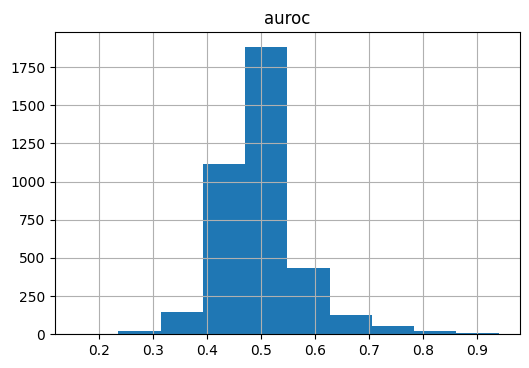

In [71]:
atac_rocs.hist()

In [72]:
atac_rocs.mean()

auroc    0.49768
dtype: float64